# Regression Model for Kaggle Tabular Playground Series August 2021 Using Python and TensorFlow
### David Lowe
### September 9, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Series Aug 2021 dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The February dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the loss from a loan default. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The performance of the cross-validated TensorFlow models achieved an average RMSE benchmark of 7.9119. When we applied the final model to Kaggle's test dataset, the model achieved an RMSE score of 7.8865.

CONCLUSION: In this iteration, the TensorFlow model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground Series Aug 2021 Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-aug-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-aug-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Sep  5 17:25:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'mean_squared_error'
DEFAULT_METRICS = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
MAX_EPOCHS = 10
BATCH_SIZE = 32

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021aug/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id        f0   f1        f2  ...       f97      f98       f99  loss
0   0 -0.002350   59  0.766739  ...  0.924090  2.29658  10.48980    15
1   1  0.784462  145 -0.463845  ...  0.439152  2.36470   1.14383     3
2   2  0.317816   19 -0.432571  ...  0.745268  1.69679  12.30550     6
3   3  0.210753   17 -0.616454  ...  0.617270  1.45645  10.02880     2
4   4  0.439671   20  0.968126  ...  0.826987  1.78485   7.07197     1

[5 rows x 102 columns]


In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 102 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   f0      float64
 2   f1      int64  
 3   f2      float64
 4   f3      float64
 5   f4      float64
 6   f5      float64
 7   f6      float64
 8   f7      float64
 9   f8      float64
 10  f9      float64
 11  f10     float64
 12  f11     float64
 13  f12     float64
 14  f13     float64
 15  f14     float64
 16  f15     float64
 17  f16     int64  
 18  f17     float64
 19  f18     float64
 20  f19     float64
 21  f20     float64
 22  f21     float64
 23  f22     float64
 24  f23     float64
 25  f24     float64
 26  f25     float64
 27  f26     float64
 28  f27     int64  
 29  f28     float64
 30  f29     float64
 31  f30     float64
 32  f31     float64
 33  f32     float64
 34  f33     float64
 35  f34     float64
 36  f35     float64
 37  f36     float64
 38  f37     float64
 39  f38     float64
 40  f

In [13]:
print(df_dataset_import.describe())

                  id             f0  ...            f99           loss
count  250000.000000  250000.000000  ...  250000.000000  250000.000000
mean   124999.500000       0.511213  ...       8.048805       6.813920
std     72168.927986       0.307884  ...       5.647368       7.940179
min         0.000000      -0.069273  ...      -0.842397       0.000000
25%     62499.750000       0.251287  ...       3.732800       1.000000
50%    124999.500000       0.514962  ...       7.182205       4.000000
75%    187499.250000       0.777323  ...      10.998550      10.000000
max    249999.000000       1.072070  ...      34.019200      42.000000

[8 rows x 102 columns]


In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id      0
f0      0
f1      0
f2      0
f3      0
       ..
f96     0
f97     0
f98     0
f99     0
loss    0
Length: 102, dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'loss':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

         f0   f1        f2        f3  ...       f97      f98       f99  target
0 -0.002350   59  0.766739 -1.350460  ...  0.924090  2.29658  10.48980      15
1  0.784462  145 -0.463845 -0.530421  ...  0.439152  2.36470   1.14383       3
2  0.317816   19 -0.432571 -0.382644  ...  0.745268  1.69679  12.30550       6
3  0.210753   17 -0.616454  0.946362  ...  0.617270  1.45645  10.02880       2
4  0.439671   20  0.968126 -0.092546  ...  0.826987  1.78485   7.07197       1

[5 rows x 101 columns]


In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 101 columns):
 #   Column  Dtype  
---  ------  -----  
 0   f0      float64
 1   f1      int64  
 2   f2      float64
 3   f3      float64
 4   f4      float64
 5   f5      float64
 6   f6      float64
 7   f7      float64
 8   f8      float64
 9   f9      float64
 10  f10     float64
 11  f11     float64
 12  f12     float64
 13  f13     float64
 14  f14     float64
 15  f15     float64
 16  f16     int64  
 17  f17     float64
 18  f18     float64
 19  f19     float64
 20  f20     float64
 21  f21     float64
 22  f22     float64
 23  f23     float64
 24  f24     float64
 25  f25     float64
 26  f26     float64
 27  f27     int64  
 28  f28     float64
 29  f29     float64
 30  f30     float64
 31  f31     float64
 32  f32     float64
 33  f33     float64
 34  f34     float64
 35  f35     float64
 36  f36     float64
 37  f37     float64
 38  f38     float64
 39  f39     float64
 40  f

In [17]:
print(df_dataset_import.describe())

                  f0             f1  ...            f99         target
count  250000.000000  250000.000000  ...  250000.000000  250000.000000
mean        0.511213      51.378476  ...       8.048805       6.813920
std         0.307884      42.396636  ...       5.647368       7.940179
min        -0.069273     -17.000000  ...      -0.842397       0.000000
25%         0.251287      18.000000  ...       3.732800       1.000000
50%         0.514962      41.000000  ...       7.182205       4.000000
75%         0.777323      75.000000  ...      10.998550      10.000000
max         1.072070     273.000000  ...      34.019200      42.000000

[8 rows x 101 columns]


In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

f0        0
f1        0
f2        0
f3        0
f4        0
         ..
f96       0
f97       0
f98       0
f99       0
target    0
Length: 101, dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

In [20]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (250000, 101) df_features_train.shape: (250000, 100) df_target_train.shape: (250000,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

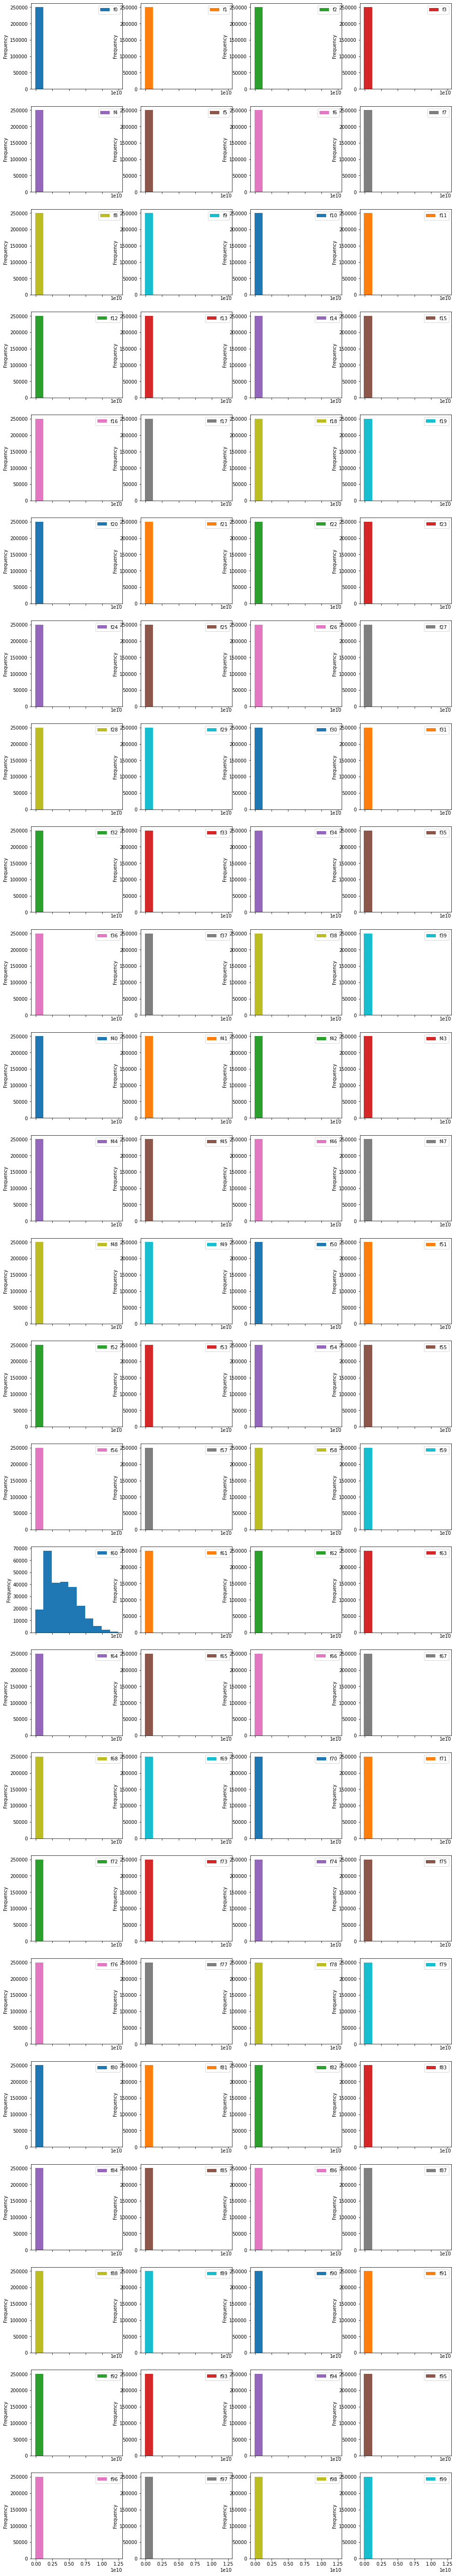

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

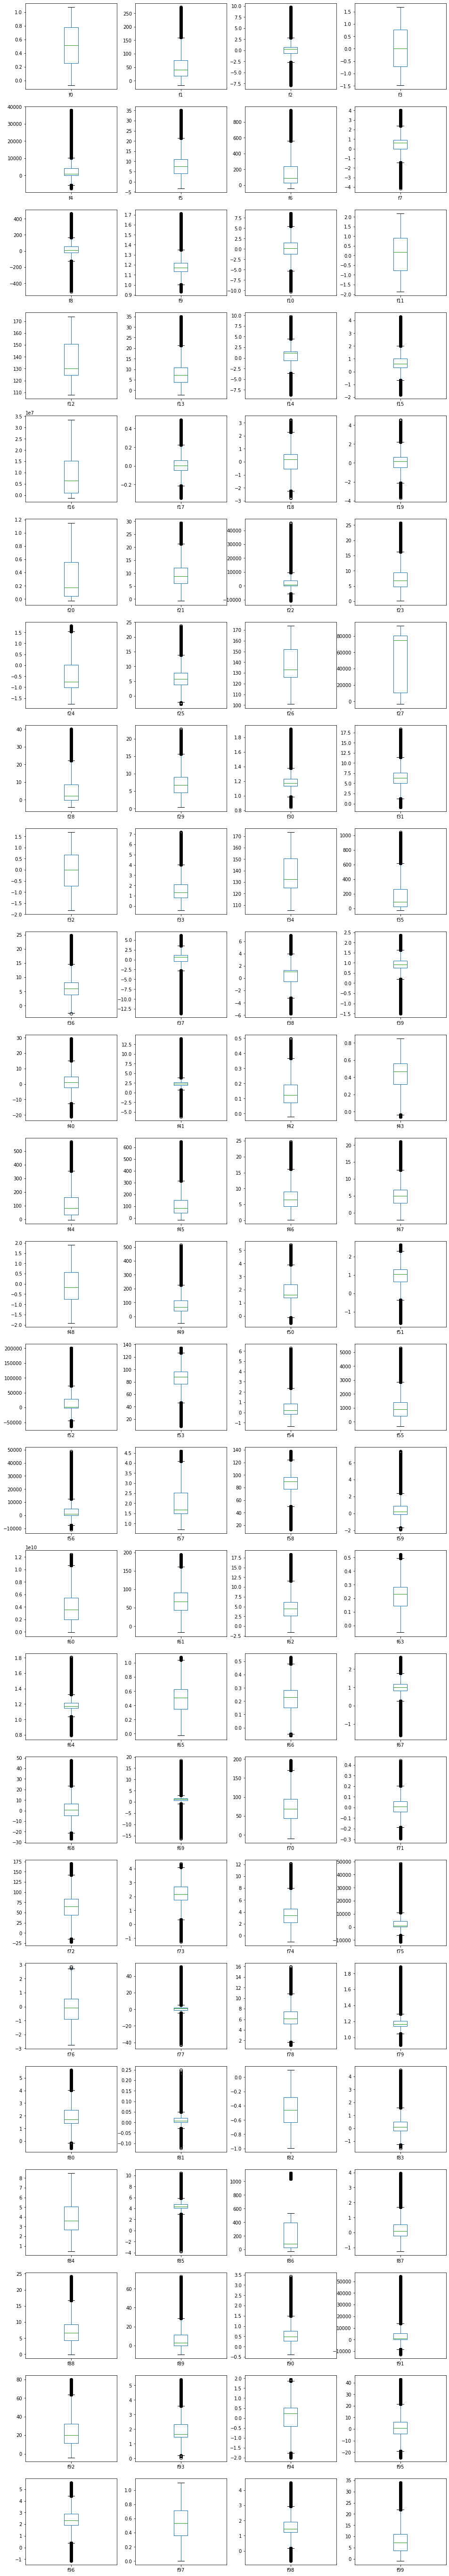

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

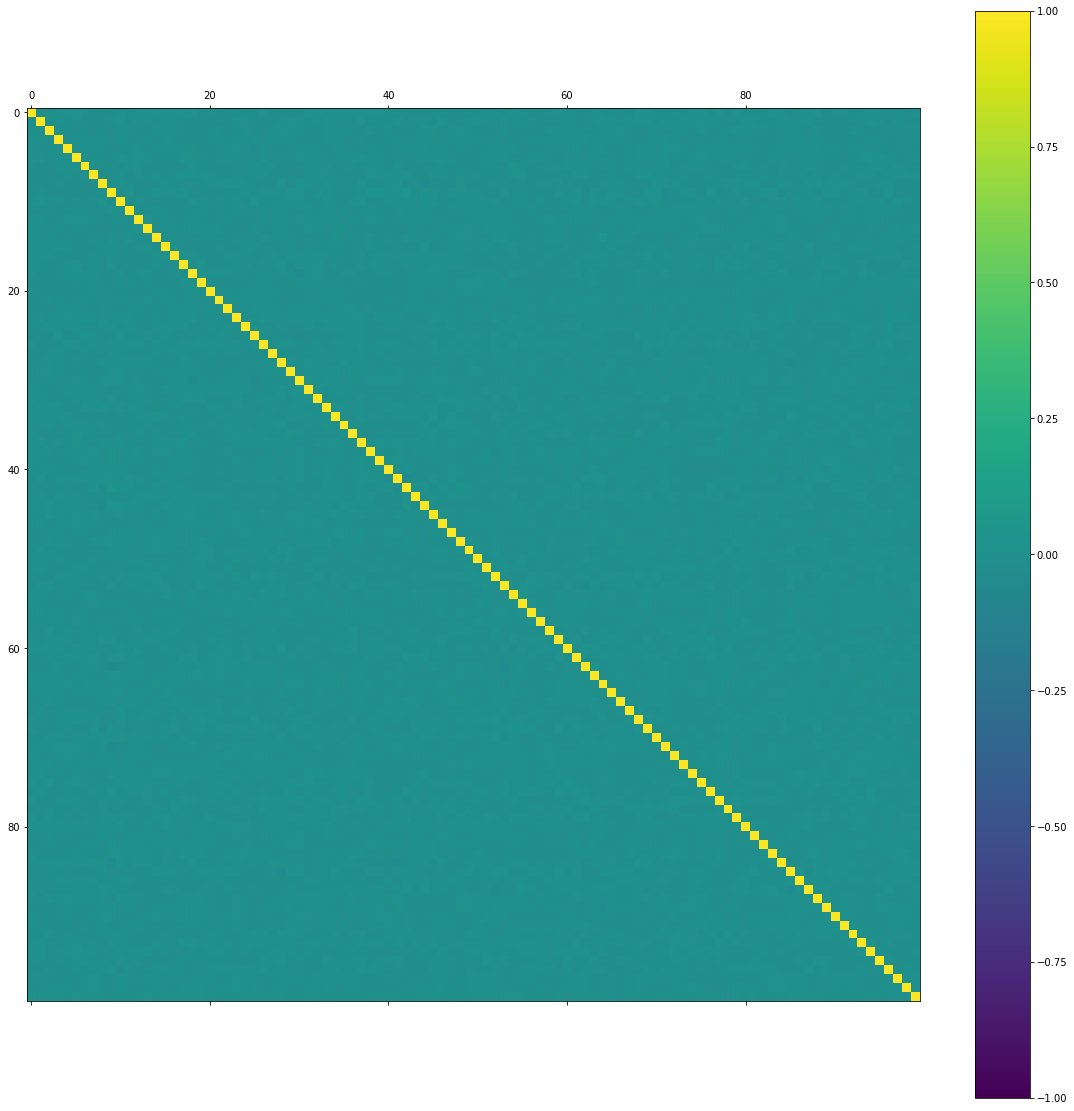

In [26]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
correlations = df_features_train.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [29]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value=0))
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 100
Number of categorical columns: 0
Total number of columns in the feature dataframe: 100


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (250000, 100) to array_features_train.shape: (250000, 100)


### 3.c) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (250000, 100) array_target_train.shape: (250000,)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [37]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1], layer1_nodes=2048, layer2_nodes=1536, layer3_nodes=1024, layer4_nodes=512, layer5_nodes=512,
                    layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25, layer4_dropout=0.25, layer5_dropout=0.5,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS, init_param=DEFAULT_INITIALIZER):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(1, kernel_initializer=init_param)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [38]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='rmse', patience=2, verbose=1, factor=0.5, min_lr=0.000001)
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction], verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=1)[1]
    iteration = iteration + 1
    print('RMSE score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model RMSE from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

1563/1563 [==============================] - 3s 2ms/step - loss: 62.2333 - rmse: 7.8888
RMSE score from iteration 1 >>> 7.8888
1563/1563 [==============================] - 3s 2ms/step - loss: 63.6852 - rmse: 7.9803
RMSE score from iteration 2 >>> 7.9803
1563/1563 [==============================] - 3s 2ms/step - loss: 62.8877 - rmse: 7.9302
RMSE score from iteration 3 >>> 7.9302
1563/1563 [==============================] - 3s 2ms/step - loss: 62.1182 - rmse: 7.8815
RMSE score from iteration 4 >>> 7.8815
1563/1563 [==============================] - 3s 2ms/step - loss: 62.0769 - rmse: 7.8789
RMSE score from iteration 5 >>> 7.8789
Average model RMSE from all iterations: 7.9119 (0.0389)
Total time for model fitting and cross validating: 0:10:46.785299


In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [41]:
final_model = create_nn_model()
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction], verbose=1)
final_model.summary()

Epoch 1/10
7813/7813 [==============================] - 27s 3ms/step - loss: 63.8513 - rmse: 7.9722
Epoch 2/10
7813/7813 [==============================] - 27s 3ms/step - loss: 63.4382 - rmse: 7.9648
Epoch 3/10
7813/7813 [==============================] - 27s 3ms/step - loss: 63.2638 - rmse: 7.9539
Epoch 4/10
7813/7813 [==============================] - 27s 3ms/step - loss: 63.2094 - rmse: 7.9504
Epoch 5/10
7813/7813 [==============================] - 27s 3ms/step - loss: 63.0078 - rmse: 7.9377
Epoch 6/10
7813/7813 [==============================] - 26s 3ms/step - loss: 62.8673 - rmse: 7.9289
Epoch 7/10
7813/7813 [==============================] - 27s 3ms/step - loss: 62.7846 - rmse: 7.9237
Epoch 8/10
7813/7813 [==============================] - 26s 3ms/step - loss: 62.7173 - rmse: 7.9194
Epoch 9/10
7813/7813 [==============================] - 26s 3ms/step - loss: 62.6339 - rmse: 7.9142
Epoch 10/10
7813/7813 [==============================] - 27s 3ms/step - loss: 62.5756 - rmse: 7.9105

### 6.b) Load Test Dataset and Prepare the Submission File

In [42]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021aug/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id        f0   f1        f2  ...      f96       f97       f98       f99
0  250000  0.812665   15 -1.239120  ...  1.94664  0.529470  1.386950   8.78767
1  250001  0.190344  131 -0.501361  ...  1.90309  0.248534  0.863881  11.79390
2  250002  0.919671   19 -0.057382  ...  1.83385  0.931796  2.336870   9.05400
3  250003  0.860985   19 -0.549509  ...  2.23251  0.893348  1.359470   4.84833
4  250004  0.313229   89  0.588509  ...  2.68238  0.361923  1.532800   3.70660

[5 rows x 101 columns]


In [43]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  250000
1  250001
2  250002
3  250003
4  250004


In [44]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

         f0   f1        f2        f3  ...      f96       f97       f98       f99
0  0.812665   15 -1.239120 -0.893251  ...  1.94664  0.529470  1.386950   8.78767
1  0.190344  131 -0.501361  0.801921  ...  1.90309  0.248534  0.863881  11.79390
2  0.919671   19 -0.057382  0.901419  ...  1.83385  0.931796  2.336870   9.05400
3  0.860985   19 -0.549509  0.471799  ...  2.23251  0.893348  1.359470   4.84833
4  0.313229   89  0.588509  0.167705  ...  2.68238  0.361923  1.532800   3.70660

[5 rows x 100 columns]


In [45]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (150000, 100) to array_features_test.shape: (150000, 100)


In [46]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[[6.9178305]
 [6.1531596]
 [6.6918902]
 ...
 [6.4832273]
 [6.5355053]
 [6.702002 ]]


In [47]:
df_kaggle_submission['loss'] = test_predictions
print(df_kaggle_submission.head())

       id    target
0  250000  6.917830
1  250001  6.153160
2  250002  6.691890
3  250003  6.929496
4  250004  6.482641


In [48]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210905-1742.csv


In [49]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [50]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:17:10.799517
